The dataset is provided by National Institute of Diabetes and Digestive and Kidney Diseases. The samples come from a database of medical information obtained from the PIMA Indians population. Specifically for this dataset, a subsection of that database was provided. The population in the sub-section belongs to females age 21 and above.

The objective is to "diagnostically predict whether or not a patient has diabetes" based on the information provided. 

**Loading Libraries and Data**

In [1]:
#loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score
import seaborn as sb
from imblearn.over_sampling import SMOTE, SMOTENC
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, GaussianNoise
from keras.callbacks import EarlyStopping
from keras import regularizers, Input
from keras import backend

Using TensorFlow backend.


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [3]:
#loading PIMA dataset
pima_df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv", delimiter = ',', header = 0)

****Preliminary Data Exploration****

In [4]:
#preview of data
pima_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [5]:
#exploring datatypes and non-null value count
pima_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


The dataset consists of 768 observations and 9 features. The data consists entirely of numeric data of int or float types. There are no missing entries in any of the columns. There are 8 predictor features and 1 target feature.

The features correspond to the following definitions:

Predictors:
* Pregnancies: The number of times the individual was pregnant.
* Glucose: The plasma glucose concentration after 2-hours (of meal). Obtained using oral glucose tolerance test.
* Blood Pressure: The diastolic blood pressure in mm-Hg. This is the pressure exerted by the blood on the artery walls between heart beats.
* Skin Thickness: The thickness of the skin in the tricep skin folds in millimeters (mm).
* Insulin: The 2-hours (of meal) insulin serum concentration in mm U/ml
* BMI: Abbreviation for Body Mass Index. Defined as the ratio between the individual's weight (in kg) and the square of the individual's height (in meters).
* Diabetes Pedigree Function: An indicator of the genetic history of diabetes in the individual.
* Age: the individual's age (in Years)

Target:
* Outcome: A binary class label. 0 indicates the individual does not have diabetes (negative class), 1 indicates that the individual has diabetes (positive class).

The dataset is clean from any null-values. The features are provided as integers with the exception of BMI and Diabetes Pedigree Function, which are floats.

In [6]:
# Computing descriptive statistics
pima_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The features have are presented in different orders of magnitude and units. They need to be centered and scaled to allow for a meaningful analysis to take place.

The features have a physical constraint that they cannot take on negative values due to the nature of these metrics. Looking at the minimum values for each feature, none violate that contraint.

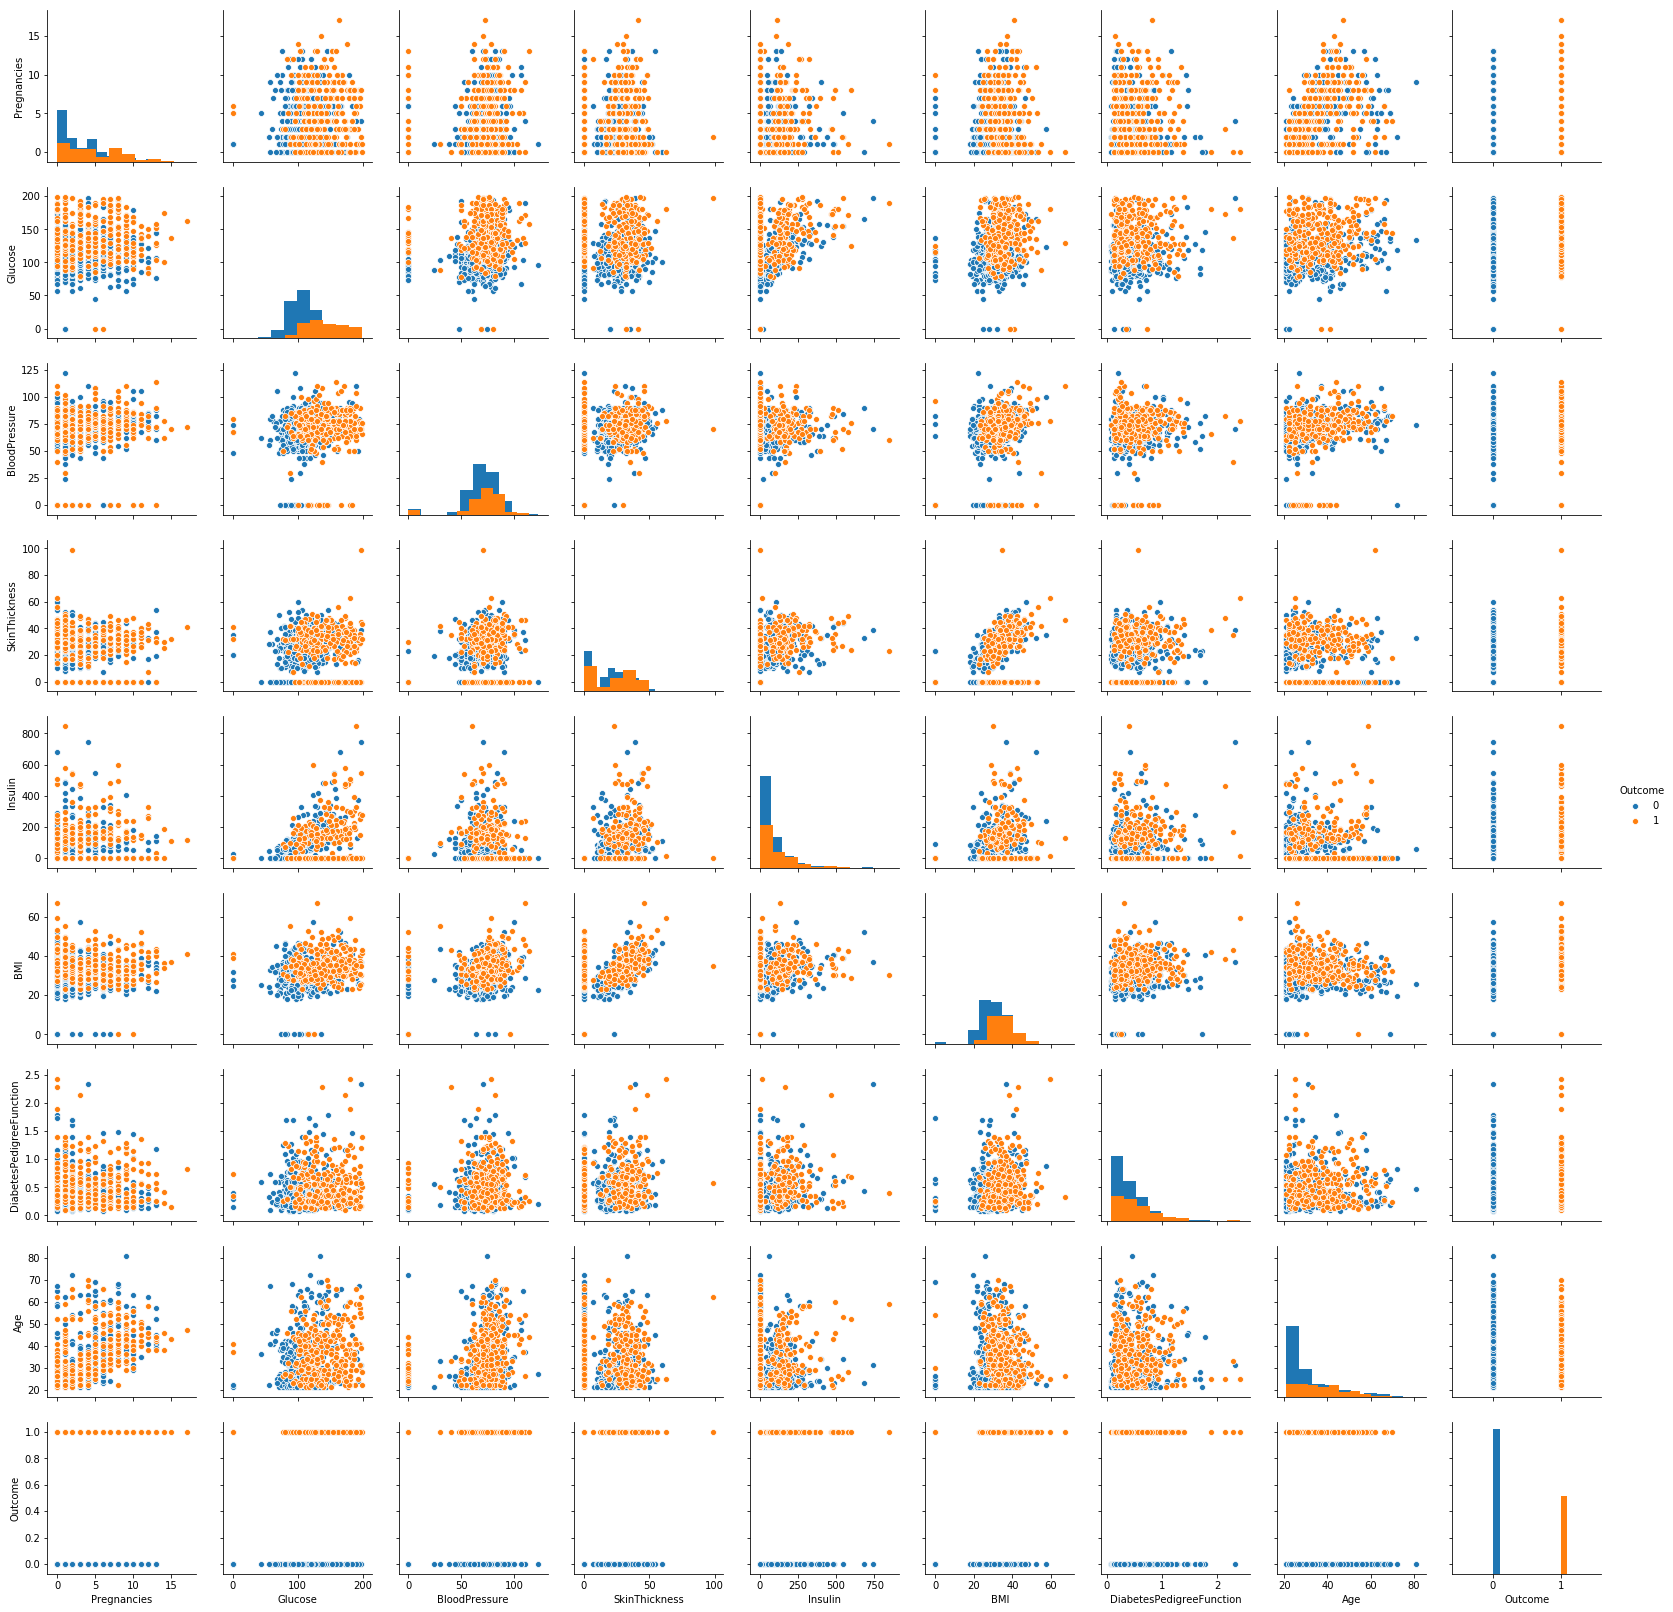

In [7]:
# bivariate scatterplots of each combination of features
sb.pairplot(pima_df, hue = 'Outcome', diag_kind = 'hist')

Each pair of features is plotted in a scatter plot. Each plot corresponds to the features indicated by the x and y labels of the chart. The diagonal of the chart correspond to the histograms of the features. The color element in the plots corresponds to the class of the observations.

Some correlations can be seen between features such as BMI and SkinThickness, as well as Glucose and BMI. It's difficult to see any features that provide a linear separation between the classes or that create distinct clusters between the classes. The bivariate plots of glucose vs the other features is the closest to doing so since we can see that the negative class is over-represented for lower values of glucose concentration.

Finally, we can observe that some values such as Glucose, Blood Pressure and BMI have some observations corresponding to measurements of zero. Having zero glucose or blood pressure cannot be sustained in a living individual. Similarly it can be noted that a BMI of zero corresponds to a weight of zero from the formula of its calculation. The same can be said for a skin thickness of zero which doesn't make physical sense. As such, these values are clearly errors and must be replaced or removed. The values will be replaced with the column medians which are a better representation of the expectation in skewed distributions. 

An insulin level of zero, however is real and can be an indicator of diabetes. 

In [8]:
# calculating column medians and storing as a dictionary
column_medians = pima_df.median().to_dict()

In [9]:
# # replacing zero values with column medians from column_medians dictionary
pima_df = pima_df.replace({
    'Glucose': {0: column_medians['Glucose']},
    'BloodPressure': {0: column_medians['BloodPressure']},
    'BMI': {0: column_medians['BMI']},
    'SkinThickness': {0: column_medians['SkinThickness']}
                           })

Finally, let's take a look at the correlations between features.

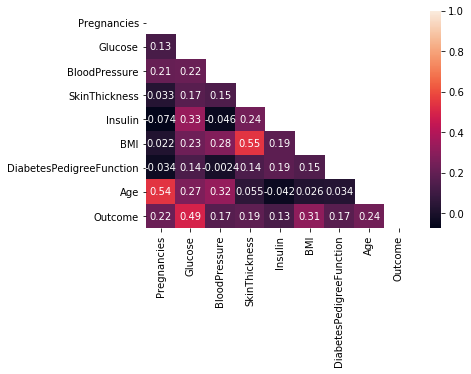

In [10]:
#calculating correlation coefficients for the features
pima_corr = pima_df.corr()

#creating mask to hide upper triangular part of matrix (mirror of bottom triangle)
mask = np.zeros_like(pima_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#plotting matrix using seaborn
sb.heatmap(pima_corr, annot = True, mask = mask)

We can confirm some of the observations seen in the pair plots. 

Predictors:
* Skin Thickness and BMI: Positive correlation of 0.55. The skin thickness is proportional to the measure of body mass/obesity. 
* Pregnancies and Age: Positive correlation of 0.54. Generally, the older individuals have had more pregnancies, having lived longer.
* Glucose and Insulin: Positive correlation of 0.33. Generally, increased blood glucose corresponds to more insulin to deal with the higher blood glucose.
* Age and BloodPressure: Positive correlation of 0.32. Generally, higher blood pressures are more prevelant in older individuals.

Target:
* Outcome seems to be most correlated with the blood glucose which we intuitively associate with diabetes, as well as body mass/degree of obesity with correlation socres of 0.49 and 0.31 respectively.

In [11]:
#exploring the target feature
pima_df.iloc[:, 8].value_counts(normalize = True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

The target variable's 2 classes are imbalanced. Class 0 has ~65% of the data while Class 1 has just over ~35%. This is an imbalanced classification problem.

**Defining Predictor and Target Variables**

In [12]:
#defining predictor features dataframe
X = pima_df.drop(columns = 'Outcome')

Pregnancies and age are commonly reported as integer values. Since we are going to deal with the class imbalances using over-sampling later on, we want to preserve the reporting of these features as only integer values. Although glucose and insulin are also provided as integers, decimal values of these features are intutive whereas they are not for pregancies. While age can take on integer values, most consider it a categorical ordinal variable so it will be treated as such.

In [13]:
#Obtaining indicator of categorical columns
categorical_columns = np.where(((X.columns=='Pregnancies') | (X.columns == 'Age')), True, False)

In [14]:
#defining target feature
y = pima_df['Outcome']

In [15]:
#converting predictor and target feature to numpy array to feed into model.
X = X.values
y = y.values

*Note that the features were not scaled at this stage, although they could. The neural network model will use batch normalization which is an alternative to scaling at this point.*

**Splitting Training and Testing Data**

Due to the imbalanced nature of data, the target feature was stratified in the splitting of data to preserve the overall distribution of classes in the training and testing sets. The random state is defined to allow for reproducibility of results. This will allow models to be compared on the same splits of data. As such, any change in performance can be more easily traced to changes in the model rather than the randomness of the data.

In [16]:
#splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 0)

**Defining Metrics for Neural Network**

This section will define custom metrics to be evaluated for the neural network. Keras makes the accuracy score avaiable as a metric but it will be helpful to define custom functions for f1-score, recall, precision, specificity, false negative fraction, and balanced accuracy.

Definition of Metrics:

* Recall or Sensitivity: True Positives/(True Positives + False Negatives)
* Precision: True Positives/(True Positives + False Positives)
* F1-Score: 2*Precision*Recall / (Precision + Recall)

In [17]:
def f1_threshold(threshold=0.5):
    """ 
    Given a threshold value, this function will take the class probabilities output by a model, apply the threshold as a decision boundary to classify the result as positive or
    negative class, then compute the f1-score between the predicted classes and the true classes. The default boundary is 0.5. Changing the threshold will make 
    class probabilities above the threshold belong to the positive class and below the threshold belong to the negative class.
    
    """
    def f1(y_true, y_pred):
        threshold_value = threshold
        
        y_true = backend.cast(backend.greater_equal(backend.clip(y_true, 0, 1), threshold_value), 'int32')
        y_pred = backend.cast(backend.greater_equal(backend.clip(y_pred, 0, 1), threshold_value), 'int32')

        true_positives = backend.cast(backend.sum(y_true*y_pred), 'float32') + backend.epsilon()
        false_positives = backend.cast(backend.shape(y_true[(y_true==0) & (y_pred==1)])[0], 'float32') + backend.epsilon()
        
        false_negatives = backend.cast(backend.shape(y_true[(y_true==1) & (y_pred==0)])[0], 'float32') + backend.epsilon()

        precision = true_positives/(true_positives + false_positives)
        recall = true_positives/(true_positives + false_negatives)

        f = 2*precision*recall/(precision + recall)
        return f
    return f1

In [18]:
def precision_threshold(threshold=0.5):
    """ 
    Given a threshold value, this function will take the class probabilities output by a model, apply the threshold as a decision boundary to classify the result as positive or
    negative class, then compute the precision score between the predicted classes and the true classes. The default boundary is 0.5. Changing the threshold will make 
    class probabilities above the threshold belong to the positive class and below the threshold belong to the negative class.
    
    """
    def precision(y_true, y_pred):
        threshold_value = threshold
        
        y_true = backend.cast(backend.greater_equal(backend.clip(y_true, 0, 1), threshold_value), 'int32')
        y_pred = backend.cast(backend.greater_equal(backend.clip(y_pred, 0, 1), threshold_value), 'int32')
        
        true_positives = backend.cast(backend.sum(y_true*y_pred), 'float32') + backend.epsilon()
        false_positives = backend.cast(backend.shape(y_true[(y_true==0) & (y_pred==1)])[0], 'float32') + backend.epsilon()

        precision = true_positives/(true_positives + false_positives)

        return precision
    
    return precision

In [19]:
def recall_threshold(threshold=0.5):
    """ 
    Given a threshold value, this function will take the class probabilities output by a model, apply the threshold as a decision boundary to classify the result as positive or
    negative class, then compute the recall score between the predicted classes and the true classes. The default boundary is 0.5. Changing the threshold will make 
    class probabilities above the threshold belong to the positive class and below the threshold belong to the negative class.
    
    """
    def recall(y_true, y_pred):
        threshold_value = threshold
        
        y_true = backend.cast(backend.greater_equal(backend.clip(y_true, 0, 1), threshold_value), 'int32')
        y_pred = backend.cast(backend.greater_equal(backend.clip(y_pred, 0, 1), threshold_value), 'int32')
        
        true_positives = backend.cast(backend.sum(y_true*y_pred), 'float32') + backend.epsilon()
        false_negatives = backend.cast(backend.shape(y_true[(y_true==1) & (y_pred==0)])[0], 'float32') + backend.epsilon()

        recall = true_positives/(true_positives + false_negatives)
    
        return recall
    return recall

In [20]:
def fn_threshold(threshold=0.5):
    """ 
    Given a threshold value, this function will take the class probabilities output by a model, apply the threshold as a decision boundary to classify the result as positive or
    negative class, then compute (1 - false-negative fraction) between the predicted classes and the true classes. The default boundary is 0.5. Changing the threshold will make 
    class probabilities above the threshold belong to the positive class and below the threshold belong to the negative class.
    
    """
    def fn(y_true, y_pred):

        threshold_value = threshold
        
        y_true = backend.cast(backend.greater_equal(backend.clip(y_true, 0, 1), threshold_value), 'int32')
        y_pred = backend.cast(backend.greater_equal(backend.clip(y_pred, 0, 1), threshold_value), 'int32')

        false_negatives = backend.cast(backend.shape(y_true[(y_true==1) & (y_pred==0)])[0], 'float32') + backend.epsilon()
        total = backend.cast(backend.shape(y_true)[0], 'float32') + backend.epsilon()

        false_negative_fraction = false_negatives/total
        
        return (1-false_negative_fraction)
    
    return fn

**Model Creation**

Here we define our keras multi-layer neural network with two layers, the first with 10 neurons and the second with 4 neurons. Both layers will using the Exponential Linear Unit (ELU) as the activation function. Batch Normalization is added to center and scale the values in the input, and after each non-linear application. A Gaussian Noise layer is added to help the model generalize and avoid overfitting.

To compile the model, binary crossentropy is used as the loss function for classification, Adam as the optimizer(learning rate = 1E-4) and the metrics defined in the above section will all be evaluated.

Model parameters can be optimized using a search space, but it will not be the focus of this notebook.

In [21]:
#initializing MLN Network
def create_network(THRESH = 0.5, weighted = False):
    """
    This function creates a pre-defined Keras multi-layer neural network and compiles it. The THRESH input to this function enables the network to compute metrics based on different
    decision boundaries for the sigmoid function in the output layer. The default boundary is 0.5. Changing the threshold will make class probabilities above the threshold belong to the
    positive class and below the threshold belong to the negative class.
    """
    model = Sequential([
        BatchNormalization(),
        GaussianNoise(0.01),
        Dense(10, activation = 'elu', input_dim = 8),
        BatchNormalization(),
        Dense(4, activation = 'elu'),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')])
    #compiling model with scoring parameters and optimizer
    metrics_list = ['accuracy', precision_threshold(THRESH), recall_threshold(THRESH), f1_threshold(THRESH), fn_threshold(THRESH)]
    
    if weighted == True:
        weighted_metrics_list = metrics_list
    else:
        weighted_metrics_list = None

    model.compile(
                  loss = 'binary_crossentropy', 
                  optimizer = keras.optimizers.Adam(1e-4),
                  metrics = metrics_list,
                  weighted_metrics = weighted_metrics_list
                 )
    return model

**Simple Model Comparison**

To evaluate our model properly let's first consider the performance of the most simple classifier. This would predict class 0 (negative) for all observation without considering the input features. 

In [22]:
#defining simple model
y_pred = np.zeros(X_test.shape[0])

In [23]:
print('Accuracy of simple model: {:.2f}'.format(accuracy_score(y_pred, y_test)))

Accuracy of simple model: 0.65


The simple model can achieve an accuracy of 0.65. This is simply the fraction of classes in our dataset that correspond to the negative class. The model can score 65% by taking advantage of the imbalance in classes. Of course, this model isn't really "predicting", and isn't using the data at all in its decision process. Any model that we create should at least beat this score to be a decent model.

**Performance and Cross Validation Strategy**

To make sure the mode generalizes well across many examples, we define a 10-fold stratified cross-validation strategy. We will apply the oversampling technique called SMOTE (Synthetic Minority Over-sampling Technique) from the Imblearn library to balance ONLY the training folds. The validation folds must remain representative of the overall distribution as well as be representative of the test set examples.

In [24]:
def cross_validate(x, y, model, k = 10, oversample = True, weight_ratio = None):
    """
    This function splits the data set aside for training into 'k' stratified folds (10 default) for training and validation. It will train a neural network model passed to it
    on the training folds and evaluate on the testing fold for all k splits. Early stopping is implemented to avoid long periods of no improvement in validation loss. The function outputs
    a dictionary of folds. For each fold a dictionary of metrics and the corresponding score is output.
    """
    kv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    
    scores_train = {}
    scores_val = {}

    
    fold = 0
    for train, val in kv.split(x, y):
        fold += 1
        
        print('Working on fold:{}'.format(fold))
        
        x_train, y_train = x[train], y[train]
        x_val, y_val = x[val], y[val]
        
        if oversample == True:
            smt = SMOTENC(categorical_features = categorical_columns)
            x_train, y_train = smt.fit_sample(x_train, y_train)
        
        es = EarlyStopping(monitor='val_loss', mode='min', patience = 20)
        
        if weight_ratio == None:
            class_weight = None
        else:    
            class_weight = {0: 1*weight_ratio, 1: 1}
            
        model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 50, 
                  batch_size = 32, class_weight = class_weight, callbacks = [es], verbose = 0)
        
        scores_train['fold' + str(fold)] = dict(zip(model.metrics_names, model.evaluate(x_train, y_train)))
        scores_val['fold' + str(fold)] = dict(zip(model.metrics_names, model.evaluate(x_val, y_val)))
        if fold == k:
            break
    
    return (scores_train, scores_val)
        

In [25]:
#creating a mode instance
network = create_network()

In [26]:
#applying cross-validation
cvs = cross_validate(x = X_train, y = y_train, model = network)

Working on fold:1
62/62 [==============================] - 0s 58us/step
Working on fold:2
62/62 [==============================] - 0s 62us/step
Working on fold:3
62/62 [==============================] - 0s 76us/step
Working on fold:4
62/62 [==============================] - 0s 63us/step
Working on fold:5
61/61 [==============================] - 0s 64us/step
Working on fold:6
61/61 [==============================] - 0s 67us/step
Working on fold:7
61/61 [==============================] - 0s 84us/step
Working on fold:8
61/61 [==============================] - 0s 63us/step
Working on fold:9
61/61 [==============================] - 0s 65us/step
Working on fold:10
61/61 [==============================] - 0s 62us/step


In [27]:
#converting results into dataframe for easy-read
cvs_train_df = pd.DataFrame(cvs[0])
cvs_val_df = pd.DataFrame(cvs[1])

In [28]:
#computing means across training folds
cvs_train_df.mean(axis = 1).round(2)

loss         0.49
accuracy     0.75
precision    0.70
recall       0.78
f1           0.72
fn           0.89
dtype: float64

In [29]:
#computing standard error for mean calculations across training folds
cvs_train_df.sem(axis= 1).round(2)

loss         0.02
accuracy     0.02
precision    0.01
recall       0.01
f1           0.01
fn           0.01
dtype: float64

In [30]:
#computing means calculations across validation folds
cvs_val_df.mean(axis = 1).round(2)

loss         0.52
accuracy     0.73
precision    0.60
recall       0.76
f1           0.66
fn           0.91
dtype: float64

In [31]:
#computing standard error for mean calculations across validation folds
cvs_val_df.sem(axis = 1).round(2)

loss         0.02
accuracy     0.02
precision    0.03
recall       0.03
f1           0.02
fn           0.01
dtype: float64

The model generalizes fairly well, with training and validation accuracies yielding similar values (0.78 and 0.75 respectively). It should be noted that this is true even though the training set was oversampled to balance the class and the validation set was not. Further attestment to the generalization ability of the model. Both outperform the simple classifier (as they should!)

With the imbalanced nature of the data, accuracy is not the best metric to evaluate a model, since even the simple classifier had a decent accuracy by "predicting" the dominant class every time.

F1-score is a better measure of model performance in imbalanced data in this case. The training f1-score is 0.75 and the validation is 0.68. For the simple classifier, the f1-score is undefined since there are no true positives (it predicted all negatives). 

More work can be done to optimize the model using search space libraries and functions to tune the number of layers, number of neurons, activation functions, optimizer, learning rate, regularization parameters, etc. But for now, we will focus on other ways to improve the model.

**Test-Set Evaluation**

In [32]:
#predicting on the test set
y_pred = network.predict_classes(X_test)

In [33]:
#calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[80, 20],
       [13, 41]])

In [34]:
#computing the accuracy between the prediction and the actual values
print('Accuracy score for test set: {:.2f}'.format(accuracy_score(y_pred, y_test)))
#computing the recall score between the prediction and actual values
print('Recall score for test set: {:.2f}'.format(recall_score(y_pred, y_test)))
#computing the precision score between the prediction and the actual values
print('Precision score for test set: {:.2f}'.format(precision_score(y_pred, y_test)))
#computing the f1-score score between the prediction and the actual values
print('F1-score for test set: {:.2f}'.format(f1_score(y_pred, y_test)))
#computing 1 minus the false_negative_fraction between the prediction and the actual values
print('1-FalseNegativeFraction for test set: {:.2f}'.format(1-cm[1, 0]/np.sum(cm)))

Accuracy score for test set: 0.79
Recall score for test set: 0.67
Precision score for test set: 0.76
F1-score for test set: 0.71
1-FalseNegativeFraction for test set: 0.92


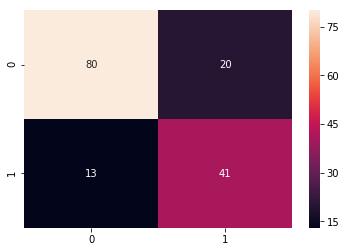

In [35]:
#heatmap of confusion matrix
sb.heatmap(cm, annot = True)

#### Changing threshold

Modifying the threshold to the metric functions can help us achieve various objectives. For example, we can find the threshold that maximizes accuracy or f1-score.

We can run the threshold in a loop to find which threshold minimizes various objectives.

In [36]:
#defining threshold search space
threshold_list = np.linspace(0, 1, 101)

In [37]:
#evaluating model at various thresholds
y_prob = network.predict(X_test)
metrics = {}
for t in threshold_list:
    t = np.round(t, 3)
    
    y_thresh = np.array([1 if i>=t else 0 for i in y_prob])
    
    cm_thresh = confusion_matrix(y_test, y_thresh)
    
    metrics[str(t)] = {}
#   computing the accuracy between the prediction and the actual values
    metrics[str(t)]['accuracy'] = accuracy_score(y_thresh, y_test)
    #computing the recall score between the prediction and actual values
    metrics[str(t)]['recall'] = recall_score(y_thresh, y_test)
    #computing the precision score between the prediction and the actual values
    metrics[str(t)]['precision'] = precision_score(y_thresh, y_test)
    #computing the f1-score score between the prediction and the actual values
    metrics[str(t)]['f1-score'] = f1_score(y_thresh, y_test)
    #computing 1 minus the false_negative_fraction between the prediction and the actual values
    metrics[str(t)]['fn'] = 1-(cm_thresh[1, 0]/np.sum(cm_thresh))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Text(0, 0.5, 'Metric Score')

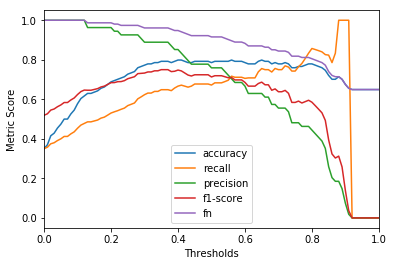

In [38]:
#plotting metrics for various thresholds
pd.DataFrame(metrics).T.plot()
plt.xlabel('Thresholds')
plt.ylabel('Metric Score')

Depending on the value of the threshold value we choose, the various metrics change according to the plot above. But there are trade-offs, we can get recall values of prevision with higher values of threshold but this comes at the expense of precision. As such we may want to choose something at their point of intersectio (~0.52). Higher values would also present a trade off between accuracy and the number of false negatives. The threshold should depend on what the application of the model is in production.

It would be a bad idea to use threshold to minimize false negatives (maximize fn). The maximum occurs at a threshold of 0. At the limit approaching the threshold, the model essentially is equivalent to a simple model that predicts all observations as the positive class (~0.35 accuracy).

#### Class Weights

Alternatively, we could specify to our model a weight for each class as an input to the model.fit function. The weight indicates to the model that how much value we want to assign to an error in a particular class. For example, if we specify {0: 1, 1:2}, the model treats each instance in class 1 as 2 instances in class 0 when calculating the error. The cost function is thus a weighted average of the cost function of each class using these weights. This is useful for class imbalances since we can assign more weight to the under-represented class.

For medical applications, we generally care more about minimizing, to a reasonable extent, the number of false negative. This would correspond to patients that are flagged by the model to belong to the negative class (no diabetes) when they, in reality, belong to the positive class. Varying the weights can help reduce the occurences of false negatives.

In [39]:
#defining new model
network_weighted = create_network(weighted = True)
#testing a weight ratio of 1:2 (equivalent to 0.5: 1)
cv_weights = cross_validate(X_train, y_train, network_weighted, weight_ratio = 0.50, oversample = True)

Working on fold:1
62/62 [==============================] - 0s 62us/step
Working on fold:2
62/62 [==============================] - 0s 69us/step
Working on fold:3
62/62 [==============================] - 0s 84us/step
Working on fold:4
62/62 [==============================] - 0s 61us/step
Working on fold:5
61/61 [==============================] - 0s 62us/step
Working on fold:6
61/61 [==============================] - 0s 58us/step
Working on fold:7
61/61 [==============================] - 0s 61us/step
Working on fold:8
61/61 [==============================] - 0s 74us/step
Working on fold:9
61/61 [==============================] - 0s 59us/step
Working on fold:10
61/61 [==============================] - 0s 66us/step


In [40]:
#results for training set
pd.DataFrame(cv_weights[0]).mean(axis = 1)

loss           0.511970
accuracy       0.756667
precision      0.674012
recall         0.868928
f1             0.740934
fn             0.934647
accuracy_1     0.756667
precision_1    0.666768
recall_1       0.870043
f1_1           0.737466
fn_1           0.937222
dtype: float64

In [41]:
#result for validation set
pd.DataFrame(cv_weights[1]).mean(axis = 1)

loss           0.570921
accuracy       0.711528
precision      0.562697
recall         0.866222
f1             0.673854
fn             0.951796
accuracy_1     0.711528
precision_1    0.563657
recall_1       0.864632
f1_1           0.673923
fn_1           0.951084
dtype: float64

In [42]:
#predicted classes with weights
y_weighted = network_weighted.predict_classes(X_test)

In [43]:
#calculating confusion matrix
cm_weighted = confusion_matrix(y_test, y_weighted)
cm_weighted

array([[70, 30],
       [ 4, 50]])

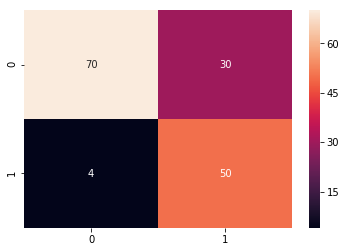

In [44]:
sb.heatmap(cm_weighted, annot = True)

Adjusting the class weights helped us minimize false negatives (maximize fn and fn_1) even further. However, this came at the expense of accuracy. If we use values even less than 0.50 for the weights, it will drive down the false negatives even further, at the cost of more accuracy.

Depending on the application, minimizing false negatives could be worthwhile still. A lot of the time it would result in more false positives. In a medical setting this would involve patients going additional tests and check-up which have their cost, but would eventually clear them of the condition. If the condition is severe, false negatives would likely take priority in minimizing and the cost associated with clearing the false positives would be justified.

#### Conclusion

We have built a multilayer neural network model in Keras that has predicted the classes well and can generalize to unseen data. 

We have also explored imbalanced data, ways to deal with the imbalance, why accuracy is not a good metric to use in imbalance datasets, and alternative metrics that are more useful.

Finally, we explored thresholds in the sigmoid decision function in the output layer of the neural network, as well as class-weights as parameters that are worthy to explore and optimize depending on the application.

The next steps would include running a wide search space for the number of layers, number of neurons in each layers, learning rate, optimizers, activation functions, noise levels, thresholds, and class-weights, to achieve an optimal combination for this problem.